In [1]:
import numpy as np
import pandas as pd

import gensim
from gensim.utils import simple_preprocess
from gensim import corpora, models

from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from symspellpy.symspellpy import SymSpell, Verbosity
from sklearn.model_selection import train_test_split

import warnings;
warnings.filterwarnings('ignore');

import process_tweet
import importlib
importlib.reload(process_tweet)

from sklearn.preprocessing import StandardScaler
def normalize_df(df):
    normed = StandardScaler().fit_transform(df)
    return pd.DataFrame(normed, columns=df.columns)

[nltk_data] Downloading package wordnet to /home/ashwin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ashwin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ashwin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [218]:
df = pd.read_csv('data/dataset_urgent_processed.csv')
df2 = pd.read_csv('data/final_dataset_processed.csv')

df = df[df['Urgency'] == 1]
df2 = df2[df2['Urgency'] == 0]

#now shuffle the values in non-urgent tweets
df2 = df2.sample(frac=1.0).reset_index(drop=True)

#add non-urgent tweets until urgent tweets make up 10% of the dataset
df3 = pd.DataFrame()
df3['Text'] = df['Text'].append(df2['Text'][:51*9], ignore_index=False)
df3['Urgency'] = df['Urgency'].append(df2['Urgency'][:51*9], ignore_index=False)
df3 = df3.reset_index(drop=True)

df = df3
df = df.sample(frac=1.0).reset_index(drop=True)

print(df.shape)
display(df.head())

# df.to_csv('data/final_urgency_dataset_unbalanced.csv', index=False)

(510, 2)


,Text,Urgency
0,hit stage tomorrow help hurricaneharvey relief...,0
1,bema say <number> pet rescue far wake harvey h...,0
2,eye lone star state harvey wreck havoc heres h...,0
3,want rescue dog leave behind hurricaneharvey,0
4,pm latest look radar houston heavy rain contin...,0


In [2]:
df = pd.read_csv('data/final_urgency_dataset_unbalanced.csv')
print(df.shape)
df.head()

(510, 2)


,Text,Urgency
0,hit stage tomorrow help hurricaneharvey relief...,0
1,bema say <number> pet rescue far wake harvey h...,0
2,eye lone star state harvey wreck havoc heres h...,0
3,want rescue dog leave behind hurricaneharvey,0
4,pm latest look radar houston heavy rain contin...,0


In [3]:
#list of embeddings
vec_length = 100
embeddings = np.zeros((1193514, vec_length))

#two-way map, index->word and word->index
glove = {}

index = 0
with open('data/glove.twitter.27B/glove.twitter.27B.%dd.txt' % vec_length) as f:
    for l in f:
        line = []
        try:
            line = l.split()
            if len(line) != vec_length+1:
                print('empty line')
                continue
            
            word = line[0]
            embeddings[index] = np.array(line[1:]).astype(np.float)
            glove[index] = word
            glove[word] = index
            index += 1
        except:
            print(line)
            print(index)
            break

empty line


In [195]:
# sym_spell = process_tweet.create_symspell(2,7,'data/frequency_dictionary_en_82_765.txt')
# tknzr = TweetTokenizer(strip_handles=False, reduce_len=True)
# df['Text'] = df['Text'].map(lambda x: process_tweet.process_tweet(x, glove, tknzr, sym_spell, True))
# df.head()

In [4]:
#only handles binary classification for now
def tweets_to_df(df, labels, embeddings, glove):
    
    weights = []
    index_omit = []
    index = -1
    tweets = df['Text']
    
    #a column for each entry in the embedding vector
    for i in range(vec_length+1):
        weights.append([])
    
    for i in range(len(tweets)):
        index += 1
        cur_embed = []
        cur_tweet = tweets[i]
        cur_label = labels[i]
        for i in cur_tweet.split():
            if i in glove:
                cur_embed.append(embeddings[glove[i]])
        
        if len(cur_embed) == 0:
            #make sure we drop this row from the input dataframe
            index_omit.append(index)
            continue
        
        x = np.asarray(np.mean(cur_embed, axis=0))
        
        for j in range(vec_length):
            weights[j].append(x[j])
        weights[vec_length].append(0 if cur_label == 0 else 1)
        #weights[vec_length].append(cur_label)
        
    df_pruned = df.drop(index_omit)
    
    #convert to dataframe
    cols = {}
    for i in range(vec_length):
       cols['v' + str(i)] = weights[i]
    
    cols['class'] = weights[vec_length]
    
    df2 = pd.DataFrame(data=cols)
    return df2

In [5]:
dfv = tweets_to_df(df, df['Urgency'], embeddings, glove)
labels = dfv.pop('class')
dfv.head()

,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v90,v91,v92,v93,v94,v95,v96,v97,v98,v99
0,0.006767,0.392471,-0.125278,-0.195383,0.012022,-0.098483,0.508877,0.164616,-0.054078,-0.216241,...,-0.058495,-0.122941,0.193241,-0.422798,0.063024,-0.227262,-0.073694,0.015016,0.148994,-0.307096
1,0.181302,0.168261,0.299544,-0.162647,-0.026963,-0.164991,0.019569,0.064372,0.113181,0.234168,...,-0.042828,-0.114721,0.014692,-0.001275,0.241052,-0.073657,0.094706,0.004472,0.262822,0.118727
2,0.031068,0.480774,-0.104659,-0.022480,0.040678,-0.206603,0.095055,-0.091968,-0.067542,-0.032950,...,0.242558,-0.069266,0.019359,-0.357889,0.204037,0.104582,0.118161,0.179778,0.264093,0.131799
3,0.273855,0.084422,0.188438,-0.022144,-0.049088,-0.219914,0.624792,-0.052922,0.352596,-0.063101,...,-0.023626,-0.169035,-0.110523,0.003578,0.256314,0.399921,-0.124767,-0.008461,0.177354,0.621590
4,0.207086,0.318976,-0.069456,-0.499206,0.213039,0.048816,0.037256,0.027811,-0.007853,-0.160614,...,-0.211119,-0.089914,0.251606,-0.336519,-0.167591,-0.051001,0.190905,0.268427,0.038993,-0.081418


In [6]:
from sklearn.base import BaseEstimator, ClassifierMixin

#this model takes in a base model and fits with resampling
#not a general class, implementation is specific to the above dataset
class ResamplingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, model):
        self.model = model
        
    def fit(self, X, y):
        
        #first resample to balance the dataset, assuming dataframe input
        X = X.copy()
        X['class'] = y
        
        df_urgent = X[X['class'] == 1]
        df_not_urgent = X[X['class'] == 0]
        df_samples = df_urgent.sample(df_not_urgent.shape[0] - df_urgent.shape[0], replace=True)
        df = pd.concat([df_not_urgent, df_samples])
        df = df.sample(frac=1.0).reset_index(drop=True)
        y = df.pop('class')
        
        self.model = self.model.fit(df, y)
        return self
    
    def predict(self, X):
        return self.model.predict(X)
    
    def predict_proba(self, X):
        return self.model.predict_proba(X)
    
    def decision_function(self, X):
        return self.model.decision_function(X)
    
    def score(self, X, y, sample_weight=None):
        return self.model.score(X, y, sample_weight)

In [7]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import * 
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import *
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score

def average(x):
    return sum(x)/len(x)

#same as for relevancy, but added resampling
def get_stats(model, X, y, cv, verbose=False):
    
    accuracy = []
    precision = []
    recall = []
    f1 = []
    auc = []
        
    cv_results = cross_validate(SMOTEClassifier(model), X, y, scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], 
                                cv=cv, return_train_score=False)
    
    if verbose:
        print(cv_results)
    
    #now return the data
    return cv_results

def print_stats(models, method, dfv, labels):
    
    vals = []
    metric = []
    model_name = []

    f1 = []
    precision = []
    recall = []
    accuracy = []
    auc = []

    cv = 3
    for k,v in models.items():
        stats = get_stats(v, dfv, labels, cv)
        accuracy_avg = np.average(stats['test_accuracy'])
        accuracy_std = np.std(stats['test_accuracy'])
        precision_avg = np.average(stats['test_precision'])
        precision_std = np.std(stats['test_precision'])
        recall_avg = np.average(stats['test_recall'])
        recall_std = np.std(stats['test_recall'])
        f1_avg = np.average(stats['test_f1'])
        f1_std = np.std(stats['test_f1'])
        auc_avg = np.average(stats['test_roc_auc'])

        f1.append('%.2f ± %.2f' % (f1_avg, f1_std))
        precision.append('%.2f ± %.2f' % (precision_avg, precision_std))
        recall.append('%.2f ± %.2f' % (recall_avg, recall_std))
        accuracy.append('%.2f ± %.2f' % (accuracy_avg, accuracy_std))
        auc.append('%.2f' % auc_avg)

    df_view = pd.DataFrame(data={'Method': method, 'f1': f1, 
                                 'precision':precision, 'recall':recall,
                                 'accuracy':accuracy, 'auc':auc})
    display(df_view)

In [20]:
models = {'Naive Bayes': GaussianNB(),
          'Voting': VotingClassifier(estimators=[('mlp', MLPClassifier()),
                                    ('ada', AdaBoostClassifier()),
                                    ('nb', GaussianNB())], voting='soft'),
          'Perceptron': MLPClassifier(),
          'AdaBoost': AdaBoostClassifier(),
          'Support Vector Machine': SVC()
        }

method = ['Naive Bayes', 'Voting', 'MLP', 'AdaBoost', 'Support Vector Machine']
print_stats(models, method, dfv, labels)

,Method,f1,precision,recall,accuracy,auc
0,Naive Bayes,0.41 ± 0.04,0.32 ± 0.01,0.59 ± 0.14,0.84 ± 0.02,0.77
1,Voting,0.43 ± 0.06,0.37 ± 0.04,0.51 ± 0.10,0.86 ± 0.01,0.79
2,MLP,0.38 ± 0.08,0.38 ± 0.05,0.41 ± 0.13,0.87 ± 0.02,0.78
3,AdaBoost,0.24 ± 0.03,0.28 ± 0.06,0.22 ± 0.03,0.86 ± 0.02,0.72
4,Support Vector Machine,0.43 ± 0.07,0.34 ± 0.07,0.65 ± 0.14,0.83 ± 0.05,0.82


## Feature Selection

We first try using randomized logistic regression to extract the most useful features from the 50.

Now we try a different approach, recursive feature elimination, and compare the selected features to those selected with randomized logistic regression.

In [39]:
from sklearn.feature_selection import RFECV

models = {'Naive Bayes': GaussianNB(),
          'Voting': VotingClassifier(estimators=[('mlp', MLPClassifier()),
                                            ('ada', AdaBoostClassifier()),
                                            ('nb', GaussianNB())], voting='soft'),
          'Perceptron': MLPClassifier(),
          'AdaBoost': AdaBoostClassifier(),
          'Support Vector Machine': SVC()
        }
method = ['Naive Bayes', 'Voting', 'MLP', 'AdaBoost', 'Support Vector Machine']
models2 = [('Logistic Regression', LogisticRegression()), ('LinearSVC', LinearSVC())]

for name, model in models2:
    rfecv = RFECV(model, step=1, scoring='f1', cv=10)
    rfecv = rfecv.fit(dfv, labels)
    mask = rfecv.support_
    
    drop_features = []
    index = 0
    for val in mask:
        if not val:
            drop_features.append('v'+str(index))
        index += 1
    
    df_rfecv = dfv.drop(drop_features, axis=1)
    print(name + ':')
    print_stats(models, method, df_rfecv, labels)

Logistic Regression:


,Method,f1,precision,recall,accuracy,auc
0,Naive Bayes,0.43 ± 0.04,0.32 ± 0.03,0.69 ± 0.07,0.82 ± 0.01,0.82
1,Voting,0.48 ± 0.07,0.40 ± 0.05,0.61 ± 0.12,0.87 ± 0.01,0.82
2,MLP,0.43 ± 0.04,0.38 ± 0.05,0.51 ± 0.07,0.86 ± 0.02,0.83
3,AdaBoost,0.35 ± 0.04,0.35 ± 0.03,0.35 ± 0.05,0.87 ± 0.00,0.75
4,Support Vector Machine,0.42 ± 0.04,0.30 ± 0.05,0.75 ± 0.06,0.79 ± 0.05,0.85


LinearSVC:


,Method,f1,precision,recall,accuracy,auc
0,Naive Bayes,0.38 ± 0.02,0.28 ± 0.01,0.61 ± 0.10,0.80 ± 0.02,0.78
1,Voting,0.48 ± 0.09,0.44 ± 0.12,0.59 ± 0.17,0.87 ± 0.03,0.84
2,MLP,0.43 ± 0.05,0.41 ± 0.04,0.47 ± 0.08,0.88 ± 0.01,0.86
3,AdaBoost,0.33 ± 0.05,0.35 ± 0.03,0.31 ± 0.07,0.87 ± 0.01,0.72
4,Support Vector Machine,0.43 ± 0.04,0.31 ± 0.03,0.69 ± 0.10,0.82 ± 0.02,0.85


In [24]:
models3 = [('Decision Tree', DecisionTreeClassifier())]

for name, model in models3:
    rfecv = RFECV(model, step=1, scoring='f1', cv=10)
    rfecv = rfecv.fit(dfv, labels)
    mask = rfecv.support_
    
    drop_features = []
    index = 0
    for val in mask:
        if not val:
            drop_features.append('v'+str(index))
        index += 1
    
    df_rfecv = dfv.drop(drop_features, axis=1)
    print(name + ':')
    print_stats(models, method, df_rfecv, labels)

Decision Tree:


,Method,f1,precision,recall,accuracy,auc
0,Naive Bayes,0.31 ± 0.06,0.22 ± 0.03,0.55 ± 0.19,0.77 ± 0.02,0.77
1,Voting,0.35 ± 0.03,0.26 ± 0.01,0.57 ± 0.14,0.79 ± 0.02,0.78
2,MLP,0.37 ± 0.04,0.27 ± 0.01,0.61 ± 0.15,0.79 ± 0.02,0.78
3,AdaBoost,0.27 ± 0.02,0.26 ± 0.02,0.27 ± 0.03,0.85 ± 0.01,0.60
4,Support Vector Machine,0.37 ± 0.05,0.28 ± 0.03,0.57 ± 0.10,0.81 ± 0.01,0.77


Now that we have gone through various feature selection methods, we conclude that RFECV with logistic regression is the best subset selection method. Our next step is to remove variables that are strongly correlated with each other (if any exist) to further prevent overfitting.

## Dimensionality Reduction with PCA

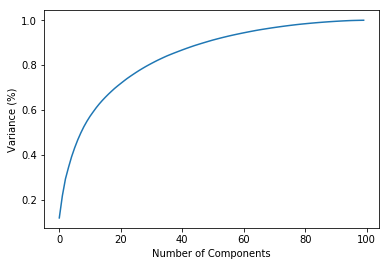

In [26]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

#rescale the data
data = dfv.values
scaler = MinMaxScaler(feature_range=[0, 1])
data_rescaled = scaler.fit_transform(data)

pca = PCA().fit(data_rescaled)

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.show()

The above calculation says that we should keep about 70 of the 100 principal components to capture over 90% of the variance in the data.

In [40]:
from sklearn.feature_selection import RFECV

#now test the models using this projected dataset
pca = PCA(n_components=60)
data_pca = pca.fit_transform(data_rescaled)
df_pca = pd.DataFrame(data_pca)

rfecv = RFECV(LogisticRegression(), step=1, scoring='f1', cv=10)
rfecv = rfecv.fit(df_pca, labels)
mask = rfecv.support_

drop_features = []
index = 0
for val in mask:
    if not val:
        drop_features.append(index)
    index += 1

df_pca = df_pca.drop(drop_features, axis=1)
print_stats(models, method, df_pca, labels)

,Method,f1,precision,recall,accuracy,auc
0,Naive Bayes,0.42 ± 0.06,0.31 ± 0.05,0.63 ± 0.07,0.82 ± 0.03,0.82
1,Voting,0.50 ± 0.05,0.43 ± 0.02,0.61 ± 0.10,0.88 ± 0.00,0.83
2,MLP,0.48 ± 0.04,0.40 ± 0.04,0.61 ± 0.07,0.87 ± 0.01,0.85
3,AdaBoost,0.40 ± 0.09,0.37 ± 0.05,0.45 ± 0.15,0.87 ± 0.01,0.74
4,Support Vector Machine,0.41 ± 0.06,0.30 ± 0.05,0.69 ± 0.07,0.80 ± 0.03,0.85


In [28]:
from sklearn.feature_selection import RFECV

#now test the models using this projected dataset
pca = PCA(n_components=40)
data_pca = pca.fit_transform(data_rescaled)
df_pca = pd.DataFrame(data_pca)

rfecv = RFECV(LogisticRegression(), scoring='f1', step=1, cv=10)
rfecv = rfecv.fit(df_pca, labels)
mask = rfecv.support_

drop_features = []
index = 0
for val in mask:
    if not val:
        drop_features.append(index)
    index += 1

df_pca = df_pca.drop(drop_features, axis=1)
print_stats(models, method, df_pca, labels)

,Method,f1,precision,recall,accuracy,auc
0,Naive Bayes,0.31 ± 0.09,0.22 ± 0.06,0.53 ± 0.17,0.77 ± 0.03,0.72
1,Voting,0.34 ± 0.03,0.31 ± 0.04,0.39 ± 0.03,0.85 ± 0.01,0.79
2,MLP,0.44 ± 0.00,0.40 ± 0.02,0.49 ± 0.03,0.87 ± 0.01,0.81
3,AdaBoost,0.28 ± 0.05,0.24 ± 0.03,0.33 ± 0.10,0.83 ± 0.01,0.67
4,Support Vector Machine,0.41 ± 0.05,0.30 ± 0.05,0.69 ± 0.07,0.80 ± 0.05,0.84


In [29]:
from sklearn.feature_selection import RFECV

#now test the models using this projected dataset
pca = PCA(n_components=20)
data_pca = pca.fit_transform(data_rescaled)
df_pca = pd.DataFrame(data_pca)

rfecv = RFECV(LogisticRegression(), scoring='f1', step=1, cv=10)
rfecv = rfecv.fit(df_pca, labels)
mask = rfecv.support_

drop_features = []
index = 0
for val in mask:
    if not val:
        drop_features.append(index)
    index += 1

df_pca = df_pca.drop(drop_features, axis=1)
print_stats(models, method, df_pca, labels)

,Method,f1,precision,recall,accuracy,auc
0,Naive Bayes,0.36 ± 0.02,0.24 ± 0.01,0.69 ± 0.10,0.76 ± 0.02,0.80
1,Voting,0.35 ± 0.02,0.24 ± 0.02,0.63 ± 0.10,0.77 ± 0.03,0.79
2,MLP,0.34 ± 0.05,0.24 ± 0.04,0.63 ± 0.15,0.76 ± 0.04,0.80
3,AdaBoost,0.28 ± 0.05,0.23 ± 0.02,0.37 ± 0.11,0.82 ± 0.01,0.72
4,Support Vector Machine,0.37 ± 0.05,0.26 ± 0.05,0.71 ± 0.10,0.76 ± 0.05,0.81


In [54]:
data = dfv.values
scaler = MinMaxScaler(feature_range=[0, 1])
data_rescaled = scaler.fit_transform(data)

pca = PCA(n_components=60)
data_pca = pca.fit_transform(data_rescaled)
df_pca = pd.DataFrame(data_pca)

models = {'Naive Bayes': GaussianNB(),
          'Voting': VotingClassifier(estimators=[('mlp', MLPClassifier(alpha=0.001)),
                                            ('ada', AdaBoostClassifier(n_estimators=100, learning_rate=0.25)),
                                            ('SVC', SVC(C=10, gamma=1, kernel='linear', 
                                                        probability=True)),
                                            ('nb', GaussianNB())], voting='soft'),
          'Perceptron': MLPClassifier(alpha=0.001),
          'AdaBoost': AdaBoostClassifier(n_estimators=100, learning_rate=0.25),
          'Support Vector Machine': SVC(C=10, degree=3, gamma=1, kernel='linear', class_weight=None)}

method = ['Naive Bayes', 'Voting', 'MLP', 'AdaBoost', 'Support Vector Machine']

#now test the models using this projected dataset
rfecv = RFECV(LogisticRegression(), step=1, scoring='f1', cv=10)
rfecv = rfecv.fit(df_pca, labels)
mask = rfecv.support_

drop_features = []
index = 0
for val in mask:
    if not val:
        drop_features.append(index)
    index += 1

df_pca = df_pca.drop(drop_features, axis=1)
print_stats(models, method, df_pca, labels)

,Method,f1,precision,recall,accuracy,auc
0,Naive Bayes,0.39 ± 0.03,0.29 ± 0.03,0.63 ± 0.06,0.81 ± 0.02,0.82
1,Voting,0.46 ± 0.03,0.39 ± 0.06,0.57 ± 0.06,0.86 ± 0.02,0.84
2,MLP,0.50 ± 0.01,0.47 ± 0.05,0.57 ± 0.10,0.89 ± 0.02,0.84
3,AdaBoost,0.33 ± 0.07,0.28 ± 0.02,0.43 ± 0.17,0.84 ± 0.01,0.75
4,Support Vector Machine,0.40 ± 0.05,0.30 ± 0.05,0.61 ± 0.06,0.82 ± 0.03,0.82


## Fine-tune Model Parameters

In [47]:
from sklearn.model_selection import GridSearchCV

#start with MLP
mlp_cv = GridSearchCV(ResamplingClassifier(MLPClassifier()), param_grid={
        'model__activation': ('logistic', 'tanh', 'relu'),
        'model__solver': ('lbfgs', 'adam'),
        'model__alpha': (0.0001, 0.001, 0.01, 0.1),
        'model__early_stopping': (True, False)}, scoring='f1', cv=10)

mlp_cv.fit(df_pca, labels)
mlp_cv.best_params_

{'model__activation': 'relu',
 'model__alpha': 0.001,
 'model__early_stopping': False,
 'model__solver': 'adam'}

In [49]:
#now try SVM
svm_cv = GridSearchCV(ResamplingClassifier(SVC()), param_grid={
        'model__kernel': ('linear', 'poly', 'rbf', 'sigmoid'),
        'model__degree': (2,3),
        'model__C': [0.001, 0.01, 0.1, 1, 10],
        'model__gamma': [0.001, 0.01, 0.1, 1],
        'model__class_weight': (None, 'balanced')}, scoring='f1', cv=10)

svm_cv.fit(df_pca, labels)
svm_cv.best_params_

{'model__C': 10,
 'model__class_weight': None,
 'model__degree': 3,
 'model__gamma': 1,
 'model__kernel': 'linear'}

In [53]:
#now try AdaBoost
ada_cv = GridSearchCV(ResamplingClassifier(AdaBoostClassifier()), param_grid={
        'model__base_estimator': (None, DecisionTreeClassifier(max_depth=2), DecisionTreeClassifier(max_depth=3)),
        'model__n_estimators': (5 0,100, 200),
        'model__learning_rate': (0.25, 0.5, 1)}, scoring='f1', cv=10)

ada_cv.fit(df_pca, labels)
ada_cv.best_params_

{'model__base_estimator': None,
 'model__learning_rate': 0.25,
 'model__n_estimators': 100}

In [56]:
#fine-tuning AdaBoost further
ada_cv2 = GridSearchCV(ResamplingClassifier(AdaBoostClassifier(n_estimators=100)), param_grid={
        'model__learning_rate': (0.05, 0.1, 0.25)}, scoring='f1', cv=10)

ada_cv2.fit(df_pca, labels)
ada_cv2.best_params_

{'model__learning_rate': 0.25}

# SMOTE Technique

Chawla, N. V., Bowyer, K. W., Hall, L. O., & Kegelmeyer, W. P. (2002). SMOTE: synthetic minority over-sampling technique. Journal of artificial intelligence research, 16, 321-357.

In [8]:
from sklearn.base import BaseEstimator, ClassifierMixin
from imblearn.over_sampling import *

#this model takes in a base model and fits after SMOTE resampling
#not a general class, implementation is specific to the above dataset
class SMOTEClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, model):
        self.model = model
        
    def fit(self, X, y):
        
        #first resample to balance the dataset, assuming dataframe input
        X_res, y_res = SVMSMOTE().fit_resample(X, y)
        self.model = self.model.fit(X_res, y_res)
        return self
    
    def predict(self, X):
        return self.model.predict(X)
    
    def predict_proba(self, X):
        return self.model.predict_proba(X)
    
    def decision_function(self, X):
        return self.model.decision_function(X)
    
    def score(self, X, y, sample_weight=None):
        return self.model.score(X, y, sample_weight)

In [9]:
models = {'Naive Bayes': GaussianNB(),
          'Voting': VotingClassifier(estimators=[('mlp', MLPClassifier()),
                                    ('ada', AdaBoostClassifier()),
                                    ('nb', GaussianNB())], voting='soft'),
          'Perceptron': MLPClassifier(),
          'AdaBoost': AdaBoostClassifier(),
          'Support Vector Machine': SVC()
        }

method = ['Naive Bayes', 'Voting', 'MLP', 'AdaBoost', 'Support Vector Machine']
print_stats(models, method, dfv, labels)

,Method,f1,precision,recall,accuracy,auc
0,Naive Bayes,0.41 ± 0.13,0.48 ± 0.17,0.37 ± 0.11,0.89 ± 0.04,0.70
1,Voting,0.40 ± 0.12,0.41 ± 0.10,0.39 ± 0.15,0.88 ± 0.02,0.76
2,MLP,0.35 ± 0.01,0.38 ± 0.06,0.35 ± 0.08,0.87 ± 0.03,0.77
3,AdaBoost,0.24 ± 0.07,0.24 ± 0.07,0.24 ± 0.08,0.85 ± 0.01,0.67
4,Support Vector Machine,0.37 ± 0.07,0.34 ± 0.04,0.43 ± 0.15,0.86 ± 0.02,0.80


## Feature Selection

Now we try a different approach, recursive feature elimination, and compare the selected features to those selected with randomized logistic regression.

In [10]:
from sklearn.feature_selection import RFECV

models = {'Naive Bayes': GaussianNB(),
          'Voting': VotingClassifier(estimators=[('mlp', MLPClassifier()),
                                            ('ada', AdaBoostClassifier()),
                                            ('nb', GaussianNB())], voting='soft'),
          'Perceptron': MLPClassifier(),
          'AdaBoost': AdaBoostClassifier(),
          'Support Vector Machine': SVC()
        }
method = ['Naive Bayes', 'Voting', 'MLP', 'AdaBoost', 'Support Vector Machine']
models2 = [('Logistic Regression', LogisticRegression()), ('LinearSVC', LinearSVC())]

for name, model in models2:
    rfecv = RFECV(model, step=1, scoring='f1', cv=10)
    rfecv = rfecv.fit(dfv, labels)
    mask = rfecv.support_
    
    drop_features = []
    index = 0
    for val in mask:
        if not val:
            drop_features.append('v'+str(index))
        index += 1
    
    df_rfecv = dfv.drop(drop_features, axis=1)
    print(name + ':')
    print_stats(models, method, df_rfecv, labels)

Logistic Regression:


,Method,f1,precision,recall,accuracy,auc
0,Naive Bayes,0.39 ± 0.06,0.58 ± 0.31,0.37 ± 0.10,0.88 ± 0.04,0.75
1,Voting,0.42 ± 0.09,0.62 ± 0.29,0.39 ± 0.12,0.89 ± 0.04,0.82
2,MLP,0.44 ± 0.03,0.45 ± 0.10,0.45 ± 0.03,0.88 ± 0.02,0.84
3,AdaBoost,0.35 ± 0.06,0.31 ± 0.07,0.41 ± 0.05,0.85 ± 0.03,0.74
4,Support Vector Machine,0.45 ± 0.05,0.39 ± 0.05,0.55 ± 0.03,0.87 ± 0.02,0.82


LinearSVC:


,Method,f1,precision,recall,accuracy,auc
0,Naive Bayes,0.31 ± 0.08,0.40 ± 0.18,0.27 ± 0.03,0.87 ± 0.04,0.74
1,Voting,0.36 ± 0.07,0.54 ± 0.19,0.27 ± 0.03,0.90 ± 0.03,0.82
2,MLP,0.45 ± 0.02,0.41 ± 0.04,0.51 ± 0.06,0.87 ± 0.01,0.87
3,AdaBoost,0.28 ± 0.07,0.29 ± 0.10,0.27 ± 0.07,0.85 ± 0.02,0.72
4,Support Vector Machine,0.44 ± 0.06,0.37 ± 0.06,0.55 ± 0.07,0.86 ± 0.02,0.83


## Dimensionality Reduction with PCA

In [11]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

#rescale the data
data = dfv.values
scaler = MinMaxScaler(feature_range=[0, 1])
data_rescaled = scaler.fit_transform(data)

pca = PCA().fit(data_rescaled)

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.show()

<Figure size 640x480 with 1 Axes>

The above calculation says that we should keep about 70 of the 100 principal components to capture over 90% of the variance in the data.

In [12]:
from sklearn.feature_selection import RFECV

#now test the models using this projected dataset
pca = PCA(n_components=60)
data_pca = pca.fit_transform(data_rescaled)
df_pca = pd.DataFrame(data_pca)

rfecv = RFECV(LogisticRegression(), step=1, scoring='f1', cv=10)
rfecv = rfecv.fit(df_pca, labels)
mask = rfecv.support_

drop_features = []
index = 0
for val in mask:
    if not val:
        drop_features.append(index)
    index += 1

df_pca = df_pca.drop(drop_features, axis=1)
print_stats(models, method, df_pca, labels)

,Method,f1,precision,recall,accuracy,auc
0,Naive Bayes,0.40 ± 0.05,0.40 ± 0.07,0.47 ± 0.17,0.86 ± 0.03,0.83
1,Voting,0.46 ± 0.07,0.45 ± 0.15,0.51 ± 0.06,0.88 ± 0.03,0.85
2,MLP,0.54 ± 0.04,0.48 ± 0.06,0.63 ± 0.03,0.89 ± 0.01,0.85
3,AdaBoost,0.43 ± 0.03,0.39 ± 0.02,0.49 ± 0.07,0.87 ± 0.01,0.80
4,Support Vector Machine,0.42 ± 0.03,0.33 ± 0.06,0.61 ± 0.06,0.83 ± 0.04,0.85


In [13]:
from sklearn.feature_selection import RFECV

#now test the models using this projected dataset
pca = PCA(n_components=40)
data_pca = pca.fit_transform(data_rescaled)
df_pca = pd.DataFrame(data_pca)

rfecv = RFECV(LogisticRegression(), scoring='f1', step=1, cv=10)
rfecv = rfecv.fit(df_pca, labels)
mask = rfecv.support_

drop_features = []
index = 0
for val in mask:
    if not val:
        drop_features.append(index)
    index += 1

df_pca = df_pca.drop(drop_features, axis=1)
print_stats(models, method, df_pca, labels)

,Method,f1,precision,recall,accuracy,auc
0,Naive Bayes,0.34 ± 0.11,0.33 ± 0.11,0.35 ± 0.13,0.86 ± 0.03,0.76
1,Voting,0.42 ± 0.10,0.43 ± 0.07,0.41 ± 0.13,0.89 ± 0.01,0.82
2,MLP,0.39 ± 0.07,0.36 ± 0.10,0.43 ± 0.03,0.86 ± 0.03,0.81
3,AdaBoost,0.36 ± 0.04,0.31 ± 0.06,0.43 ± 0.03,0.84 ± 0.03,0.76
4,Support Vector Machine,0.44 ± 0.06,0.33 ± 0.07,0.69 ± 0.03,0.82 ± 0.04,0.84


In [42]:
pca = PCA(n_components=60)
data_pca = pca.fit_transform(data_rescaled)
df_pca = pd.DataFrame(data_pca)

models = {'Naive Bayes': GaussianNB(),
          'Voting': VotingClassifier(estimators=[('mlp', MLPClassifier(alpha=0.01)),
                                            ('ada', AdaBoostClassifier(n_estimators=100, learning_rate=0.25)),
                                            ('SVC', SVC(C=0.01, degree=2, gamma=1, kernel='poly', 
                                                        class_weight=None, probability=True)),
                                            ('nb', GaussianNB())], voting='soft'),
          'Perceptron': MLPClassifier(alpha=0.01),
          'AdaBoost': AdaBoostClassifier(n_estimators=100, learning_rate=0.25),
          'Support Vector Machine': SVC(C=1, gamma=0.001, kernel='linear', class_weight=None)}

method = ['Naive Bayes', 'Voting', 'MLP', 'AdaBoost', 'Support Vector Machine']

#now test the models using this projected dataset
rfecv = RFECV(LogisticRegression(), step=1, scoring='f1', cv=10)
rfecv = rfecv.fit(df_pca, labels)
mask = rfecv.support_

drop_features = []
index = 0
for val in mask:
    if not val:
        drop_features.append(index)
    index += 1

df_pca = df_pca.drop(drop_features, axis=1)
print_stats(models, method, df_pca, labels)

,Method,f1,precision,recall,accuracy,auc
0,Naive Bayes,0.40 ± 0.10,0.39 ± 0.04,0.43 ± 0.17,0.88 ± 0.00,0.77
1,Voting,0.46 ± 0.10,0.58 ± 0.11,0.41 ± 0.13,0.91 ± 0.02,0.83
2,MLP,0.51 ± 0.02,0.43 ± 0.02,0.63 ± 0.07,0.88 ± 0.01,0.85
3,AdaBoost,0.38 ± 0.06,0.35 ± 0.08,0.43 ± 0.03,0.86 ± 0.03,0.78
4,Support Vector Machine,0.49 ± 0.02,0.42 ± 0.03,0.61 ± 0.07,0.87 ± 0.02,0.87


## Fine-tune Model Parameters

In [24]:
from sklearn.model_selection import GridSearchCV

#start with MLP
mlp_cv = GridSearchCV(SMOTEClassifier(MLPClassifier()), param_grid={
        'model__activation': ('logistic', 'tanh', 'relu'),
        'model__solver': ('adam',),
        'model__alpha': (0.0001, 0.001, 0.01, 0.1)}, scoring='f1', cv=10)

mlp_cv.fit(df_pca, labels)
mlp_cv.best_params_

{'model__activation': 'relu', 'model__alpha': 0.01, 'model__solver': 'adam'}

In [25]:
lol = pd.DataFrame(mlp_cv.cv_results_)[['param_model__activation', 'param_model__alpha', 'mean_test_score']]
lol

,param_model__activation,param_model__alpha,mean_test_score
0,logistic,0.0001,0.533922
1,logistic,0.001,0.498885
2,logistic,0.01,0.503233
3,logistic,0.1,0.496904
4,tanh,0.0001,0.516899
5,tanh,0.001,0.525838
6,tanh,0.01,0.542613
7,tanh,0.1,0.533052
8,relu,0.0001,0.511300
9,relu,0.001,0.558595


In [ ]:
#now try SVM
svm_cv = GridSearchCV(SMOTEClassifier(SVC()), param_grid={
        'model__kernel': ('linear', 'poly', 'rbf', 'sigmoid'),
        'model__degree': (2,3),
        'model__C': [0.001, 0.01, 0.1, 1, 10],
        'model__gamma': [0.001, 0.01, 0.1, 1, 10],
        'model__class_weight': (None, 'balanced')}, scoring='f1', cv=10)

svm_cv.fit(df_pca, labels)
svm_cv.best_params_

In [33]:
#now try AdaBoost
ada_cv = GridSearchCV(SMOTEClassifier(AdaBoostClassifier(base_estimator=DecisionTreeClassifier())), param_grid={
        'model__base_estimator__max_depth': (1,2,3),
        'model__n_estimators': (50,100, 200),
        'model__learning_rate': (0.25, 0.5, 1)}, scoring='f1', cv=10)

ada_cv.fit(df_pca, labels)
ada_cv.best_params_

{'model__base_estimator__max_depth': 2,
 'model__learning_rate': 0.25,
 'model__n_estimators': 100}

In [34]:
lol = pd.DataFrame(ada_cv.cv_results_)[['param_model__base_estimator', 'param_model__n_estimators', 
                                        'param_model__learning_rate','mean_test_score']]
lol

KeyError: "['param_model__base_estimator'] not in index"

In [35]:
lol = pd.DataFrame(ada_cv.cv_results_)[['param_model__base_estimator__max_depth', 'param_model__n_estimators', 
                                        'param_model__learning_rate','mean_test_score']]
lol

,param_model__base_estimator__max_depth,param_model__n_estimators,param_model__learning_rate,mean_test_score
0,1,50,0.25,0.386970
1,1,100,0.25,0.359798
2,1,200,0.25,0.430456
3,1,50,0.5,0.388900
4,1,100,0.5,0.395024
5,1,200,0.5,0.410380
6,1,50,1,0.381126
7,1,100,1,0.360801
8,1,200,1,0.393098
9,2,50,0.25,0.429383
